### Задача

Определеить режимы стрельбы из 23 мм нарезной бикалиберной пушки полиэтиленом для того, чтобы что-то доказать)) (где он застревает, а где рвется после конуса.

Параметры пушки:
- $d$ = 23 мм;
- $W_{каморы}$ = 42 см$^3$;
- $L_{ствола}$ = 887 мм;
- конусы: 23-16-100-100, 23-18-100-100, 23-14-80-120;
- порох 4\\7.

In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [45]:
from tube import InterpXY,Tube,BorderSimple
from math import *
import numpy as np
from powderlayer import PowderBD, PowderOvLayer, Powder
from pistonlayer import ElPistEOS, ElPistLayer
import pprint as pp

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [4]:
import json
from functional import seq

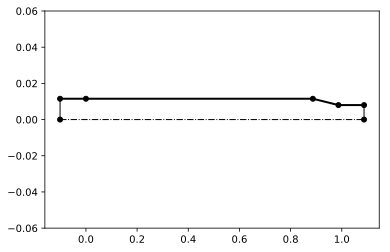

In [30]:
tube2316=Tube.get_standart({
    'tube_points': [[0, 0.023], [0.887, 0.023], [0.987, 0.016], [1.087, 0.016]]
})
W_0 = 42 * 1e-6
x_left = -tube2316.get_x2(0, W_0)
tube2316=Tube.get_standart({
    'tube_points': [[x_left, 0.023],[0, 0.023], [0.887, 0.023], [0.987, 0.016], [1.087, 0.016]]
})

tube = tube2316
ax, fig = plt.subplots()
tube2316.plot(ax, fig)
fig.set_ylim(-0.06,0.06)
plt.show()

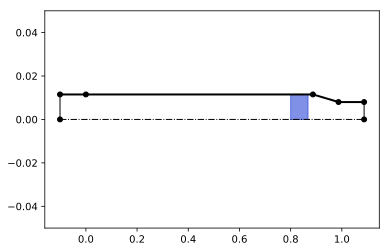

ElPistLayer(n_cells=300); 
        {'p_max':100000.0, 'tau_min': 9.425696139142217e-08, 
        'u_max': 100.0, 'cs_max': 2308.0384458555504, 'dx_min': 0.00022697438682006688, 
        'x_1': 0.8, 'x_2': 0.8680923160460452,
        'V_1':  0.0, 'V_2':  0.0  }

In [31]:
v0 = 100
pist_layer_dict_sample = {
    'type': 'pist',
    'omega': 0.026,  # кг
    'p_0': 1e5, # начальное давление в полиэтилене
    'u_0': v0,     #начальная скорость
    'ElPistEOS_kwargs': dict(
        k=1.63098, 
        c_0=2308, 
        ro_0=919.03, 
        sigma_star=25.2, 
        k_0=0.054, 
        b_1=0.027, 
        b_2=0.00675, 
        tau_0=1.36, 
        mu=0.001, 
        tau_s=1,                 
        zeroP=False, 
        zeroE=True)
}


calc_settings_sample2 = {
    'cell_dx': 0.0001,
#     'n_cells': 600,
    'n_cells_min': 13,
    'n_cells_max': 300,
    'GasFluxCalculator_kwargs': {'flux_type':1, 'x_order':1, 'alpha_1':1, 'alpha_2':0.5},
    'GridStrecher_kwargs': {}
}   
pistl = ElPistLayer.get_standart(tube2316, 0.8, pist_layer_dict_sample, calc_settings_sample2)   


fig, ax = plt.subplots()
pistl.plot(fig, ax,plot_tube=True)
ax.set_ylim(-0.05,0.05)
plt.show()

pistl

In [32]:
pistl.flux_calculator.get_Vs_border_svobodn(pistl, 1e5,1e5)

(100.0, 100.0)

In [33]:
lrs = [pistl]
vl,vr = pistl.flux_calculator.get_Vs_border_svobodn(pistl, 1e5,1e5)
x1, x2 = 0.1, 0.2
for i in range(30000):
    tau = pistl.get_tau_min()*0.3
    x = pistl.xs_borders[0]
    mnj = (x - x1) / (x2 - x1)
    vl,vr = pistl.flux_calculator.get_Vs_border_svobodn(pistl, 1e5,1e5)
    pistl = pistl.step_simple(tau, vl, vr)
    lrs.append(pistl)
    if pistl.time > 0.005:
        break
len(lrs)

30001

In [34]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=100, value=0))
def plotMe(ind):
    param_name = 'us'
    lr = lrs[ind]
    fig, ax = plt.subplots()
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax.plot(xs, ys, color=color, lw=lw, label=param_name)
#     ys = np.array(getattr(lr, 'us'))
#     ax.plot(xs, ys, lw=lw, label='us')
#     ys = np.array(getattr(lr, 'ps'))/1e4
#     ax.plot(xs, ys, lw=lw, label='ps')
#     ys = np.array(getattr(lr, 'es'))
#     ax.plot(xs, ys, lw=lw, label='es')
    plt.grid(True)
    plt.ylabel(param_name)
    plt.xlim(0.8,1.3)
#     plt.ylim(-30,200)
    plt.title(f't={lr.time*1000} ms; i={ind}')
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=30000, step=100), Output()), _dom_classes=('wi…

In [43]:
def get_powder_layer(omega, tube):
    powder_layer_dict_sample = {
        'type': 'powder',
        'powder': PowderBD()['4\\7'],
        'omega': omega,  # грамм
        'delta': omega/W_0*1e-3, # кг/m^3
        'p_0': 5e6, # начальное давление
        't_ign': 0,#0.000001, # начало горения
        'u_0': 0,     #начальная скорость
    }

    calc_settings_sample = {
        'cell_dx': 0.0025,
        'n_cells_min': 13,
        'n_cells_max': 300,
        'GasFluxCalculator_kwargs': {'flux_type':2},
        'GridStrecher_kwargs': {}
    }  
    pl = PowderOvLayer.get_standart(tube, tube.get_xs()[0], powder_layer_dict_sample, calc_settings_sample)
    return pl

def get_piston_layer(omega, tube):
    pist_layer_dict_sample = {
    'type': 'pist',
    'omega': omega/1000,  # кг
    'p_0': 1e5, # начальное давление в полиэтилене
    'u_0': 0,     #начальная скорость
    'ElPistEOS_kwargs': dict(
        k=1.63098, 
        c_0=2308, 
        ro_0=919.03, 
        sigma_star=25.2, 
        k_0=0.054, 
        b_1=0.027, 
        b_2=0.00675, 
        tau_0=1.36, 
        mu=0.001, 
        tau_s=1,                 
        zeroP=False, 
        zeroE=True)
    }
    calc_settings_sample2 = {
        'cell_dx': 0.0005,
    #     'n_cells': 600,
        'n_cells_min': 13,
        'n_cells_max': 300,
        'GasFluxCalculator_kwargs': {'flux_type':1, 'x_order':1, 'alpha_1':1, 'alpha_2':0.5},
        'GridStrecher_kwargs': {}
    }   
    pistl = ElPistLayer.get_standart(tube, 0, pist_layer_dict_sample, calc_settings_sample2)   
    return pistl

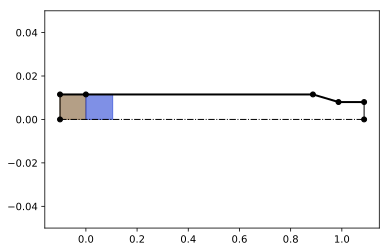

In [44]:
pl = get_powder_layer(33, tube)
pistl = get_piston_layer(40, tube)

fig, ax = plt.subplots()
tube.plot(fig, ax)
pl.plot(fig, ax)
pistl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

In [ ]:
def get_solutions(omega, pistonomega, m_op, p_f, tube):
    plr = get_powder_layer(omega, tube)
    pistlr = get_piston_layer(pistonomega, tube)
    border_dict_sample = {
        'mass': m_op, # kg
        'p_f': p_f, #Pa
        't_init': -1,
        'w_border': 0.005, #m
    }
    border = BorderSimple.get_standart(border_dict_sample)
    